# ttbar Analysis - Jet-Parton Assignment Training

This is the training notebook for the jet-parton assignment task. The goal is to associate the leading four jets in each event to their associated parent particles. We are trying to assign jets according to the labels in the diagram below:

<img src="utils/ttbar.png" alt="ttbar_labels" width="500"/>

top1 and top2 jets do not necessarily correspond to top/antitop, respectively. The top1 jet is defined as having a lepton/neutrino pair as cousins, where the top2 jet is defined as having two jets as cousins. The W jets are not distinguished from each other.

The strategy for solving this problem is to train a boosted decision tree to find the correct assignments for each jet. Since we consider four jets per event with three unique labels (W, top1, and top2), there are twelve possible combinations of assignments:

<img src="utils/jetcombinations.png" alt="jetcombinations" width="700"/>

The combination with the highest BDT score will be selected for each event.
____

The workflow for this training notebook is outlined as follows:
* Load data and calculate training features and labels using `coffea`/`dask`
* Optimize BDT (`xgboost` model) using `hyperopt` (TODO: Track using `mlflow`)
* Save best model (TODO: save to `onnx`)

In [1]:
import asyncio
import time
import logging

import vector; vector.register_awkward()

import cabinetry
from coffea.nanoevents.schemas.base import BaseSchema, zip_forms
from coffea.nanoevents import NanoAODSchema
from coffea import processor
from coffea.nanoevents.methods import base, vector
from coffea.nanoevents import transforms
import awkward as ak
import numpy as np
import hist
import json
import matplotlib.pyplot as plt
import uproot

import torch
import onnx

import utils

import mlflow
import mlflow.xgboost
from mlflow.models.signature import infer_signature

logging.getLogger("cabinetry").setLevel(logging.INFO)

/opt/conda/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.0.0)/charset_normalizer (2.0.9) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
### GLOBAL CONFIGURATION

# input files per process, set to e.g. 10 (smaller number = faster, want to use larger number for training)
N_FILES_MAX_PER_SAMPLE = 1
# set to "dask" for DaskExecutor, "futures" for FuturesExecutor
EXEC = "dask"

# number of cores if using FuturesExecutor
NUM_CORES = 16

# chunk size to use
CHUNKSIZE = 100_000

# analysis facility: set to "coffea_casa" for coffea-casa environments, "EAF" for FNAL, "local" for local setups
AF = "coffea_casa"

In [3]:
## functions for calculating features and labels for the BDT
def training_filter(jets, electrons, muons, genparts):
    '''
    Filters events down to training set and calculates jet-level labels
    
    Args:
        jets: selected jets after region filter (and selecting leading four for each event)
        electrons: selected electrons after region filter
        muons: selected muons after region filter
        genparts: selected genpart after region filter
    
    Returns:
        jets, electrons, muons, labels
    '''
    #### filter genPart to valid matching candidates ####

    # get rid of particles without parents
    genpart_parent = genparts.distinctParent
    genpart_filter = np.invert(ak.is_none(genpart_parent, axis=1))
    genparts = genparts[genpart_filter]
    genpart_parent = genparts.distinctParent

    # ensure that parents are top quark or W
    genpart_filter2 = ((np.abs(genpart_parent.pdgId)==6) | (np.abs(genpart_parent.pdgId)==24))
    genparts = genparts[genpart_filter2]

    # ensure particle itself is a quark
    genpart_filter3 = ((np.abs(genparts.pdgId)<7) & (np.abs(genparts.pdgId)>0))
    genparts = genparts[genpart_filter3]

    # get rid of duplicates
    genpart_filter4 = genparts.hasFlags("isLastCopy")
    genparts = genparts[genpart_filter4]
            
        
    #### get jet-level labels and filter events to training set
        
    # match jets to nearest valid genPart candidate
    nearest_genpart = jets.nearest(genparts, threshold=0.4)
    nearest_parent = nearest_genpart.distinctParent # parent of matched particle

    parent_pdgid = nearest_parent.pdgId # pdgId of parent particle
    grandchild_pdgid = nearest_parent.distinctChildren.distinctChildren.pdgId # pdgId of particle's parent's grandchildren

    grandchildren_flat = np.abs(ak.flatten(grandchild_pdgid,axis=-1)) # flatten innermost axis for convenience

    # if particle has a cousin that is a lepton
    has_lepton_cousin = (ak.sum(((grandchildren_flat%2==0) & (grandchildren_flat>10) & (grandchildren_flat<19)),
                                axis=-1)>0)
    # if particle has a cousin that is a neutrino
    has_neutrino_cousin = (ak.sum(((grandchildren_flat%2==1) & (grandchildren_flat>10) & (grandchildren_flat<19)),
                                  axis=-1)>0)

    # if a particle has a lepton cousin and a neutrino cousin
    has_both_cousins = ak.fill_none((has_lepton_cousin & has_neutrino_cousin), False).to_numpy()

    # get labels from parent pdgId (fill none with 100 to filter out events with those jets)
    labels = np.abs(ak.fill_none(parent_pdgid,100).to_numpy())
    labels[has_both_cousins] = -6 # assign jets with both cousins as top1 (not necessarily antiparticle)

    training_event_filter = (np.sum(labels,axis=1)==48) # events with a label sum of 48 have the correct particles
            
    # filter events
    jets = jets[training_event_filter]
    electrons = electrons[training_event_filter]
    muons = muons[training_event_filter]
    labels = labels[training_event_filter]
    
    return jets, electrons, muons, labels
    

def get_training_set(jets, electrons, muons, labels):
    '''
    Calculate features for each of the 12 combinations per event and calculates combination-level labels
    
    Args:
        jets: selected jets after training filter
        electrons: selected electrons after training filter
        muons: selected muons after training filter
        labels: jet-level labels output by training_filter
    
    Returns:
        features, labels (flattened to remove event level)
    '''
    
#     # permutations of jets to consider
#     permutation_ind = np.array([[0,1,2,3],[0,1,3,2],[0,2,1,3],[0,3,1,2],
#                                 [0,2,3,1],[0,3,2,1],[2,0,1,3],[3,0,1,2],
#                                 [2,0,3,1],[3,0,2,1],[2,3,0,1],[3,2,0,1]])
#     # corresponding jet labels to above permutations
#     permutation_labels = np.array([[24,24,6,-6],[24,24,-6,6],[24,6,24,-6],[24,-6,24,6],
#                                    [24,6,-6,24],[24,-6,6,24],[6,24,24,-6],[-6,24,24,6],
#                                    [6,24,-6,24],[-6,24,6,24],[6,-6,24,24],[-6,6,24,24]])

    permutation_ind = np.array([[0,1,2,3],[0,1,3,2],[0,2,1,3],[0,2,3,1],
                                [0,3,1,2],[0,3,2,1],[1,2,0,3],[1,2,3,0],
                                [1,3,0,2],[1,3,2,0],[2,3,0,1],[2,3,1,0]])
    permutation_labels = np.array([[24,24,6,-6],[24,24,-6,6],[24,6,24,-6],[24,-6,24,6],
                                   [24,6,-6,24],[24,-6,6,24],[6,24,24,-6],[-6,24,24,6],
                                   [6,24,-6,24],[-6,24,6,24],[6,-6,24,24],[-6,6,24,24]])
    
    
    #### calculate features ####
    
    features = np.zeros((len(jets),12,19))
                        
    # grab lepton info
    lepton_eta = (ak.sum(electrons.eta,axis=-1) + ak.sum(muons.eta,axis=-1)).to_numpy().reshape((len(jets),1))
    lepton_phi = (ak.sum(electrons.phi,axis=-1) + ak.sum(muons.phi,axis=-1)).to_numpy().reshape((len(jets),1))
    lepton_mass = (ak.sum(electrons.mass,axis=-1) + ak.sum(muons.mass,axis=-1)).to_numpy().reshape((len(jets),1))
    
    # delta R between top1 and lepton
    features[:,:,0] = np.sqrt((lepton_eta - jets[:,permutation_ind[:,3]].eta)**2 + 
                              (lepton_phi - jets[:,permutation_ind[:,3]].phi)**2)

    # delta R between the two W
    features[:,:,1] = np.sqrt((jets[:,permutation_ind[:,0]].eta - jets[:,permutation_ind[:,1]].eta)**2 + 
                              (jets[:,permutation_ind[:,0]].phi - jets[:,permutation_ind[:,1]].phi)**2)

    # delta R between W and top2
    features[:,:,2] = np.sqrt((jets[:,permutation_ind[:,0]].eta - jets[:,permutation_ind[:,2]].eta)**2 + 
                              (jets[:,permutation_ind[:,0]].phi - jets[:,permutation_ind[:,2]].phi)**2)
    features[:,:,3] = np.sqrt((jets[:,permutation_ind[:,0]].eta - jets[:,permutation_ind[:,2]].eta)**2 + 
                              (jets[:,permutation_ind[:,1]].phi - jets[:,permutation_ind[:,2]].phi)**2)

    # delta phi between top1 and lepton
    features[:,:,4] = np.abs(lepton_phi - jets[:,permutation_ind[:,3]].phi)

    # delta phi between the two W
    features[:,:,5] = np.abs(jets[:,permutation_ind[:,0]].phi - jets[:,permutation_ind[:,1]].phi)

    # delta phi between W and top2
    features[:,:,6] = np.abs(jets[:,permutation_ind[:,0]].phi - jets[:,permutation_ind[:,2]].phi)
    features[:,:,7] = np.abs(jets[:,permutation_ind[:,1]].phi - jets[:,permutation_ind[:,2]].phi)

    # combined mass of top1 and lepton
    features[:,:,8] = lepton_mass + jets[:,permutation_ind[:,3]].mass

    # combined mass of W
    features[:,:,9] = jets[:,permutation_ind[:,0]].mass + jets[:,permutation_ind[:,1]].mass

    # combined mass of W and top2
    features[:,:,10] = jets[:,permutation_ind[:,0]].mass + jets[:,permutation_ind[:,1]].mass + jets[:,permutation_ind[:,2]].mass

    # pt of every jet
    features[:,:,11] = jets[:,permutation_ind[:,0]].pt
    features[:,:,12] = jets[:,permutation_ind[:,1]].pt
    features[:,:,13] = jets[:,permutation_ind[:,2]].pt
    features[:,:,14] = jets[:,permutation_ind[:,3]].pt

    # mass of every jet
    features[:,:,15] = jets[:,permutation_ind[:,0]].mass
    features[:,:,16] = jets[:,permutation_ind[:,1]].mass
    features[:,:,17] = jets[:,permutation_ind[:,2]].mass
    features[:,:,18] = jets[:,permutation_ind[:,3]].mass

    
    #### calculate combination-level labels ####
    
    # which combination does the truth label correspond to?
    which_combination = np.zeros(len(jets), dtype=int)
    # no correct matches
    which_anti_combination = np.zeros(labels.shape[0], dtype=int)
    for i in range(12):
        which_combination[(labels[:]==permutation_labels[i,:]).all(1)] = i
        which_anti_combination[np.invert((labels[:]==permutation_labels[i,:]).any(1))] = i

    # convert to combination-level truth label (-1, 0 or 1)
    which_combination = list(zip(range(len(jets),), which_combination))
    which_anti_combination = list(zip(range(labels.shape[0],), which_anti_combination))
    
    truth_labels = -1*np.ones((len(jets),12))
    for i,tpl in enumerate(which_combination):
        truth_labels[tpl]=1
    for i,tpl in enumerate(which_anti_combination):
        truth_labels[tpl]=0
        
        
    #### flatten to combinations (easy to unflatten since each event always has 12 combinations) ####
    labels = truth_labels.reshape((truth_labels.shape[0]*truth_labels.shape[1],1))
    features = features.reshape((features.shape[0]*features.shape[1],features.shape[2]))    
        
    return features, labels, which_combination

### Defining a `coffea` Processor

The processor returns the training features and labels we will use in our BDT

In [4]:
processor_base = processor.ProcessorABC
class JetClassifier(processor_base):
    def __init__(self):
        super().__init__()
    
    def process(self, events):
        
        process = events.metadata["process"]  # "ttbar" etc.
        variation = events.metadata["variation"]  # "nominal" etc.
        
        # normalization for MC
        x_sec = events.metadata["xsec"]
        nevts_total = events.metadata["nevts"]
        lumi = 3378 # /pb
        xsec_weight = x_sec * lumi / nevts_total
            
        events["pt_nominal"] = 1.0
        pt_variations = ["pt_nominal"] if variation == "nominal" else ["pt_nominal"]
        for pt_var in pt_variations:
            
            # filter electrons, muons, and jets by pT
            selected_electrons = events.Electron[events.Electron.pt > 30]
            selected_muons = events.Muon[events.Muon.pt > 30]
            jet_filter = events.Jet.pt > 30
            selected_jets = events.Jet[jet_filter]
            selected_genpart = events.GenPart
            
            # single lepton requirement
            event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
            # require at least 4 jets
            event_filters = event_filters & (ak.count(selected_jets.pt, axis=1) >= 4)
            # require at least one jet above B_TAG_THRESHOLD
            B_TAG_THRESHOLD = 0.8
            event_filters = event_filters & (ak.sum(selected_jets.btagCSVV2 >= B_TAG_THRESHOLD, axis=1) >= 1)
            
            # apply event filters
            selected_events = events[event_filters]
            selected_electrons = selected_electrons[event_filters]
            selected_muons = selected_muons[event_filters]
            selected_jets = selected_jets[event_filters]
            selected_genpart = selected_genpart[event_filters]
            
            ### only consider 4j2b region
            region_filter = ak.sum(selected_jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) >= 2 # at least two b-tagged jets
            selected_jets_region = selected_jets[region_filter][:,:4] # only keep top 4 jets
            selected_electrons_region = selected_electrons[region_filter]
            selected_muons_region = selected_muons[region_filter]
            selected_genpart_region = selected_genpart[region_filter]
            
            # filter events and calculate labels
            jets, electrons, muons, labels = training_filter(selected_jets_region, 
                                                             selected_electrons_region, 
                                                             selected_muons_region, 
                                                             selected_genpart_region)
            
            # calculate features and labels
            features, labels, which_combination = get_training_set(jets, electrons, muons, labels)
    
        output = {"nevents": {events.metadata["dataset"]: len(events)},
                  "features": {events.metadata["dataset"]: features.tolist()},
                  "labels": {events.metadata["dataset"]: labels.tolist()},
                  "which_combination": {events.metadata["dataset"]: which_combination},}
            
        return output
        
    def postprocess(self, accumulator):
        return accumulator

### "Fileset" construction and metadata

Here, we gather all the required information about the files we want to process: paths to the files and asociated metadata.

In [5]:
fileset = utils.construct_fileset(N_FILES_MAX_PER_SAMPLE, 
                                  use_xcache=False, 
                                  json_file = 'ntuples_nanoaod_agc.json')

# get rid of everything except ttbar__nominal for training purposes
fileset_keys = list(fileset.keys())
for key in fileset_keys:
    if key!="ttbar__nominal":
        fileset.pop(key)

In [6]:
fileset

{'ttbar__nominal': {'files': ['https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0000.root'],
  'metadata': {'process': 'ttbar',
   'variation': 'nominal',
   'nevts': 1334428,
   'xsec': 729.84}}}

### Execute the data delivery pipeline

In [ ]:
schema = NanoAODSchema

if EXEC == "futures":
    executor = processor.FuturesExecutor(workers=NUM_CORES)
elif EXEC == "dask":
    executor = processor.DaskExecutor(client=utils.get_client(AF))
    
run = processor.Runner(executor=executor, schema=schema, savemetrics=True, metadata_cache={}, chunksize=CHUNKSIZE)

# preprocess
filemeta = run.preprocess(fileset, treename="Events")

# process
output, metrics = run(fileset, 
                      "Events", 
                      processor_instance = JetClassifier())

In [8]:
# import pickle
# pickle.dump(output, open("output_1.p", "wb"))

In [7]:
import pickle
output = pickle.load(open("output_2.p", "rb"))

In [8]:
# grab features and labels and convert to np array
features = np.array(output['features']['ttbar__nominal'])
labels = np.array(output['labels']['ttbar__nominal'])
labels = labels.reshape((len(labels),))

In [9]:
# investigate labels
print(len(labels))
print(len(labels)/12)
print(sum(labels==1))

1500000
125000.0
125000


The key for the labeling scheme is as follows

* 1: all jet assignments are correct
* 0: some jet assignments are correct (one or two are correct, others are incorrect)
* -1: all jet assignments are incorrect

There are twelve combinations for each event, so each event will have 1 correct combination, 2 completely incorrect combinations, and 9 partially correct combinations.

In [8]:
# separate by label for plotting
all_correct = features[labels==1,:]
some_correct = features[labels==-1,:]
none_correct = features[labels==0,:]

# Histograms of Training Variables
To vizualize the separation power of the different variables, histograms are created for each of the three labels. Only `all_correct` and `none_correct` are used for training purposes.

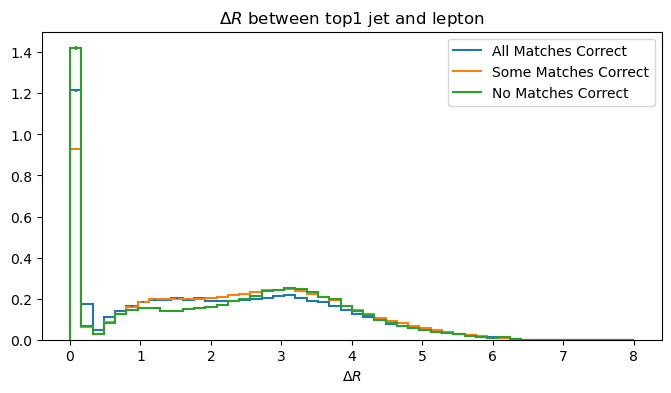

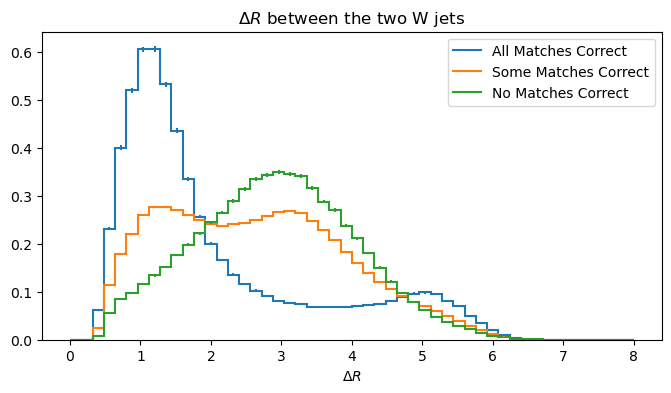

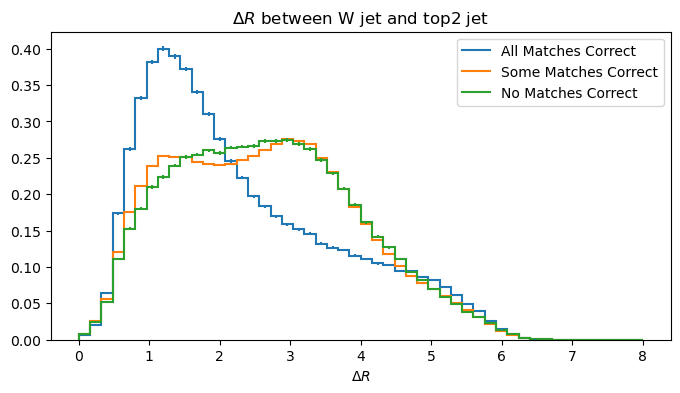

In [8]:
#### delta R histogram ####

# binning
deltar_low = 0.0
deltar_high = 8.0
deltar_numbins = 100
legend_list = ["All Matches Correct", "Some Matches Correct", "No Matches Correct"]

# define histogram
h = hist.Hist(
    hist.axis.Regular(deltar_numbins, deltar_low, deltar_high, name="deltar", label="$\Delta R$", flow=False),
    hist.axis.StrCategory(legend_list, name="truthlabel", label="Truth Label"),
    hist.axis.StrCategory(["top1_lepton","W_W","top2_W"], name="category", label="Category"),
)

# fill histogram
h.fill(deltar = all_correct[:,0], category="top1_lepton", truthlabel="All Matches Correct")
h.fill(deltar = some_correct[:,0], category="top1_lepton", truthlabel="Some Matches Correct")
h.fill(deltar = none_correct[:,0], category="top1_lepton", truthlabel="No Matches Correct")
h.fill(deltar = all_correct[:,1], category="W_W", truthlabel="All Matches Correct")
h.fill(deltar = some_correct[:,1], category="W_W", truthlabel="Some Matches Correct")
h.fill(deltar = none_correct[:,1], category="W_W", truthlabel="No Matches Correct")
h.fill(deltar = all_correct[:,2], category="top2_W", truthlabel="All Matches Correct")
h.fill(deltar = some_correct[:,2], category="top2_W", truthlabel="Some Matches Correct")
h.fill(deltar = none_correct[:,2], category="top2_W", truthlabel="No Matches Correct")
h.fill(deltar = all_correct[:,3], category="top2_W", truthlabel="All Matches Correct")
h.fill(deltar = some_correct[:,3], category="top2_W", truthlabel="Some Matches Correct")
h.fill(deltar = none_correct[:,3], category="top2_W", truthlabel="No Matches Correct")

# make plots
fig,ax = plt.subplots(1,1,figsize=(8,4))
h[0j::hist.rebin(2), :, "top1_lepton"].plot(density=True, ax=ax)
ax.legend(legend_list)
ax.set_title("$\Delta R$ between top1 jet and lepton")
fig.show()

fig,ax = plt.subplots(1,1,figsize=(8,4))
h[0j::hist.rebin(2), :, "W_W"].plot(density=True, ax=ax)
ax.legend(legend_list)
ax.set_title("$\Delta R$ between the two W jets")
fig.show()

fig,ax = plt.subplots(1,1,figsize=(8,4))
h[0j::hist.rebin(2), :, "top2_W"].plot(density=True, ax=ax)
ax.legend(legend_list)
ax.set_title("$\Delta R$ between W jet and top2 jet")
fig.show()

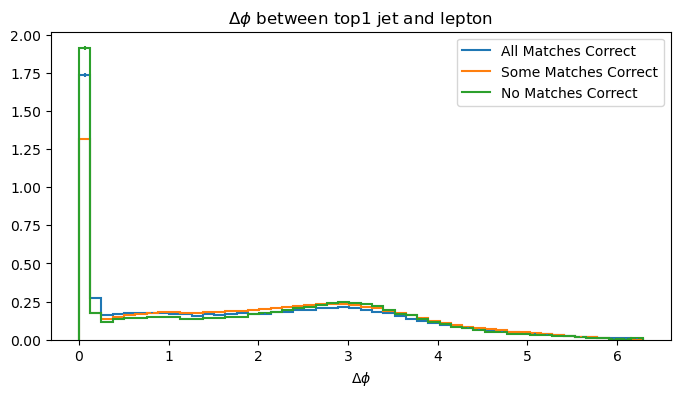

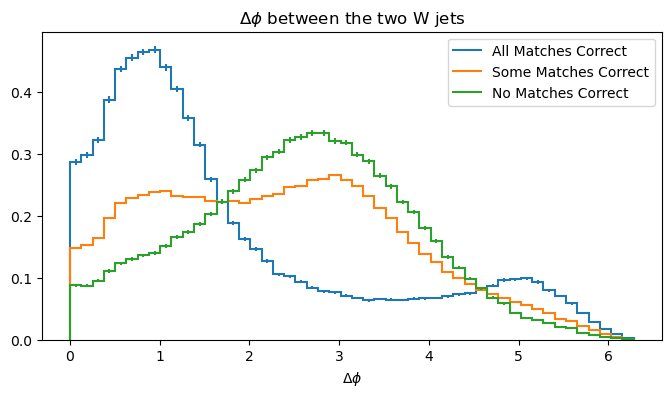

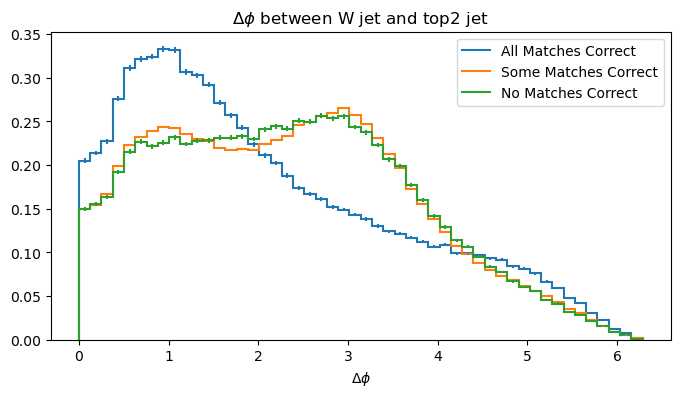

In [9]:
#### delta phi histogram ####

# binning
deltaphi_low = 0.0
deltaphi_high = 2*np.pi
deltaphi_numbins = 100
legend_list = ["All Matches Correct", "Some Matches Correct", "No Matches Correct"]

# define histogram
h = hist.Hist(
    hist.axis.Regular(deltaphi_numbins, deltaphi_low, deltaphi_high, name="deltaphi", label="$\Delta \phi$", flow=False),
    hist.axis.StrCategory(legend_list, name="truthlabel", label="Truth Label"),
    hist.axis.StrCategory(["top1_lepton","W_W","top2_W"], name="category", label="Category"),
)

# fill histogram
h.fill(deltaphi = all_correct[:,4], category="top1_lepton", truthlabel="All Matches Correct")
h.fill(deltaphi = some_correct[:,4], category="top1_lepton", truthlabel="Some Matches Correct")
h.fill(deltaphi = none_correct[:,4], category="top1_lepton", truthlabel="No Matches Correct")
h.fill(deltaphi = all_correct[:,5], category="W_W", truthlabel="All Matches Correct")
h.fill(deltaphi = some_correct[:,5], category="W_W", truthlabel="Some Matches Correct")
h.fill(deltaphi = none_correct[:,5], category="W_W", truthlabel="No Matches Correct")
h.fill(deltaphi = all_correct[:,6], category="top2_W", truthlabel="All Matches Correct")
h.fill(deltaphi = some_correct[:,6], category="top2_W", truthlabel="Some Matches Correct")
h.fill(deltaphi = none_correct[:,6], category="top2_W", truthlabel="No Matches Correct")
h.fill(deltaphi = all_correct[:,7], category="top2_W", truthlabel="All Matches Correct")
h.fill(deltaphi = some_correct[:,7], category="top2_W", truthlabel="Some Matches Correct")
h.fill(deltaphi = none_correct[:,7], category="top2_W", truthlabel="No Matches Correct")

# make plots
fig,ax = plt.subplots(1,1,figsize=(8,4))
h[0j::hist.rebin(2), :, "top1_lepton"].plot(density=True, ax=ax)
ax.legend(legend_list)
ax.set_title("$\Delta \phi$ between top1 jet and lepton")
fig.show()

fig,ax = plt.subplots(1,1,figsize=(8,4))
h[0j::hist.rebin(2), :, "W_W"].plot(density=True, ax=ax)
ax.legend(legend_list)
ax.set_title("$\Delta \phi$ between the two W jets")
fig.show()

fig,ax = plt.subplots(1,1,figsize=(8,4))
h[0j::hist.rebin(2), :, "top2_W"].plot(density=True, ax=ax)
ax.legend(legend_list)
ax.set_title("$\Delta \phi$ between W jet and top2 jet")
fig.show()

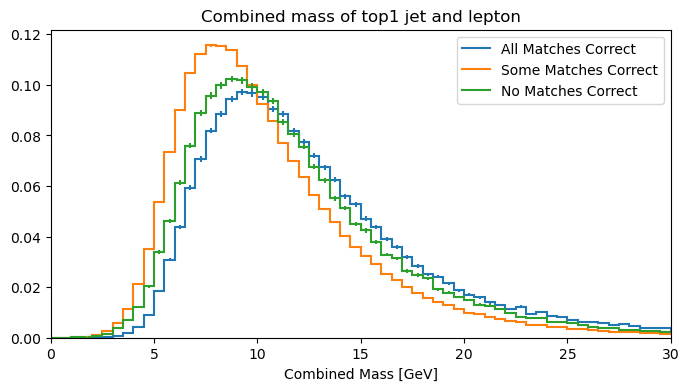

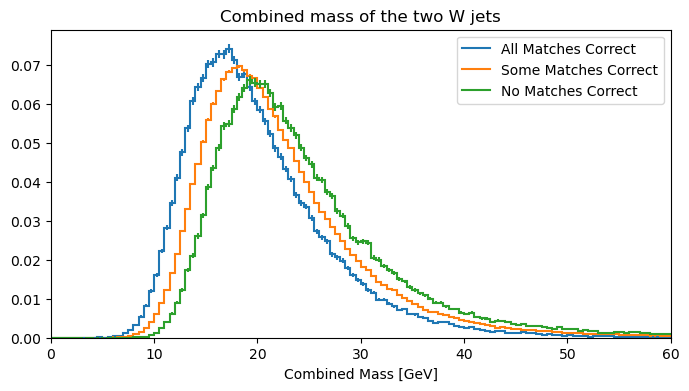

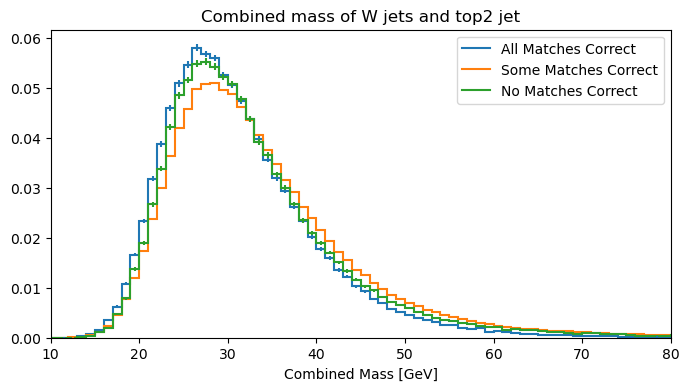

In [10]:
#### mass histogram ####

# binning
combinedmass_low = 0.0
combinedmass_high = 100.0
combinedmass_numbins = 200
legend_list = ["All Matches Correct", "Some Matches Correct", "No Matches Correct"]

# define histogram
h = hist.Hist(
    hist.axis.Regular(combinedmass_numbins, combinedmass_low, combinedmass_high, 
                      name="combinedmass", label="Combined Mass [GeV]", flow=False),
    hist.axis.StrCategory(legend_list, name="truthlabel", label="Truth Label"),
    hist.axis.StrCategory(["top1_lepton","W_W","top2_W_W"], name="category", label="Category"),
)

# fill histogram
h.fill(combinedmass = all_correct[:,8], category="top1_lepton", truthlabel="All Matches Correct")
h.fill(combinedmass = some_correct[:,8], category="top1_lepton", truthlabel="Some Matches Correct")
h.fill(combinedmass = none_correct[:,8], category="top1_lepton", truthlabel="No Matches Correct")
h.fill(combinedmass = all_correct[:,9], category="W_W", truthlabel="All Matches Correct")
h.fill(combinedmass = some_correct[:,9], category="W_W", truthlabel="Some Matches Correct")
h.fill(combinedmass = none_correct[:,9], category="W_W", truthlabel="No Matches Correct")
h.fill(combinedmass = all_correct[:,10], category="top2_W_W", truthlabel="All Matches Correct")
h.fill(combinedmass = some_correct[:,10], category="top2_W_W", truthlabel="Some Matches Correct")
h.fill(combinedmass = none_correct[:,10], category="top2_W_W", truthlabel="No Matches Correct")

# make plots
fig,ax = plt.subplots(1,1,figsize=(8,4))
h[:, :, "top1_lepton"].plot(density=True, ax=ax)
ax.legend(legend_list)
ax.set_title("Combined mass of top1 jet and lepton")
ax.set_xlim([0,30])
fig.show()

fig,ax = plt.subplots(1,1,figsize=(8,4))
h[:, :, "W_W"].plot(density=True, ax=ax)
ax.legend(legend_list)
ax.set_title("Combined mass of the two W jets")
ax.set_xlim([0,60])
fig.show()

fig,ax = plt.subplots(1,1,figsize=(8,4))
h[0j::hist.rebin(2), :, "top2_W_W"].plot(density=True, ax=ax)
ax.legend(legend_list)
ax.set_title("Combined mass of W jets and top2 jet")
ax.set_xlim([10,80])
fig.show()

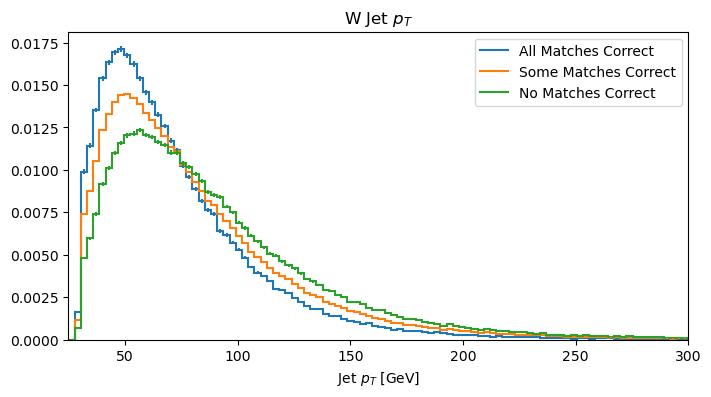

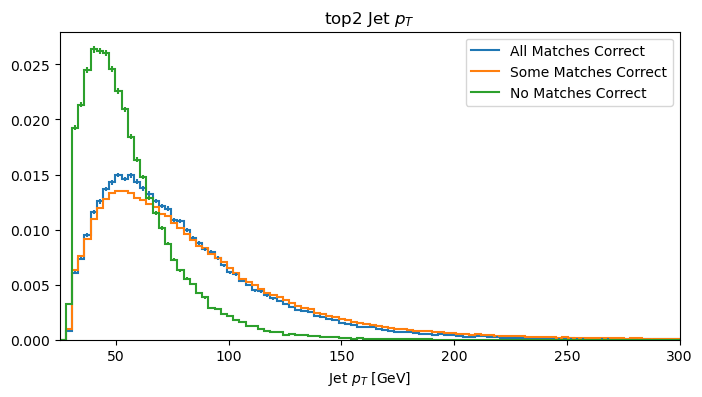

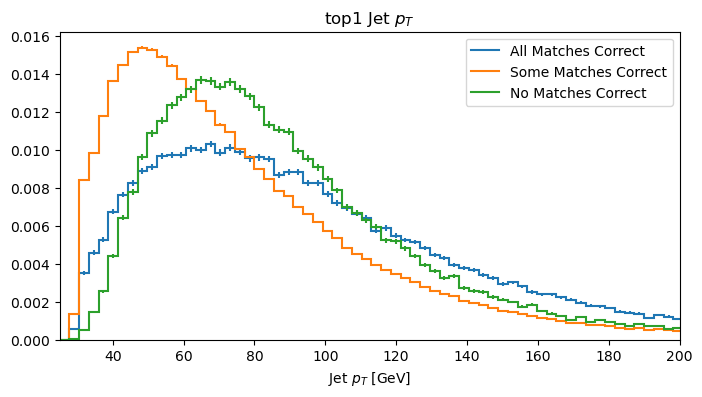

In [11]:
#### pT histogram ####

# binning
pt_low = 25.0
pt_high = 300.0
pt_numbins = 100
legend_list = ["All Matches Correct", "Some Matches Correct", "No Matches Correct"]

# define histogram
h = hist.Hist(
    hist.axis.Regular(pt_numbins, pt_low, pt_high, 
                      name="jetpt", label="Jet $p_T$ [GeV]", flow=False),
    hist.axis.StrCategory(legend_list, name="truthlabel", label="Truth Label"),
    hist.axis.StrCategory(["W","top1","top2"], name="category", label="Category"),
)

# fill histogram
h.fill(jetpt = all_correct[:,11], category="W", truthlabel="All Matches Correct")
h.fill(jetpt = some_correct[:,11], category="W", truthlabel="Some Matches Correct")
h.fill(jetpt = none_correct[:,11], category="W", truthlabel="No Matches Correct")
h.fill(jetpt = all_correct[:,12], category="W", truthlabel="All Matches Correct")
h.fill(jetpt = some_correct[:,12], category="W", truthlabel="Some Matches Correct")
h.fill(jetpt = none_correct[:,12], category="W", truthlabel="No Matches Correct")
h.fill(jetpt = all_correct[:,13], category="top2", truthlabel="All Matches Correct")
h.fill(jetpt = some_correct[:,13], category="top2", truthlabel="Some Matches Correct")
h.fill(jetpt = none_correct[:,13], category="top2", truthlabel="No Matches Correct")
h.fill(jetpt = all_correct[:,14], category="top1", truthlabel="All Matches Correct")
h.fill(jetpt = some_correct[:,14], category="top1", truthlabel="Some Matches Correct")
h.fill(jetpt = none_correct[:,14], category="top1", truthlabel="No Matches Correct")

# make plots
fig,ax = plt.subplots(1,1,figsize=(8,4))
h[:, :, "W"].plot(density=True, ax=ax)
ax.legend(legend_list)
ax.set_title("W Jet $p_T$")
ax.set_xlim([25,300])
fig.show()

fig,ax = plt.subplots(1,1,figsize=(8,4))
h[:, :, "top2"].plot(density=True, ax=ax)
ax.legend(legend_list)
ax.set_title("top2 Jet $p_T$")
ax.set_xlim([25,300])
fig.show()

fig,ax = plt.subplots(1,1,figsize=(8,4))
h[:, :, "top1"].plot(density=True, ax=ax)
ax.legend(legend_list)
ax.set_title("top1 Jet $p_T$")
ax.set_xlim([25,200])
fig.show()

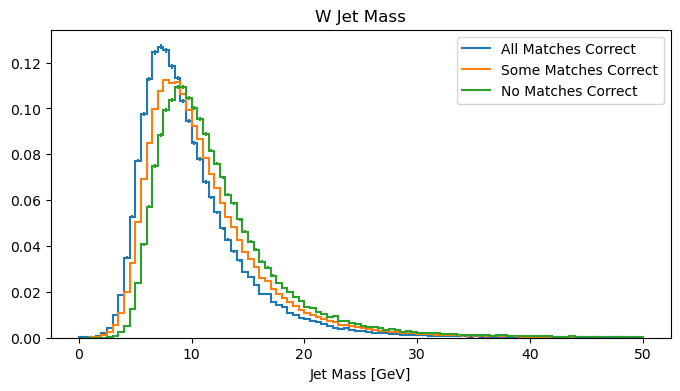

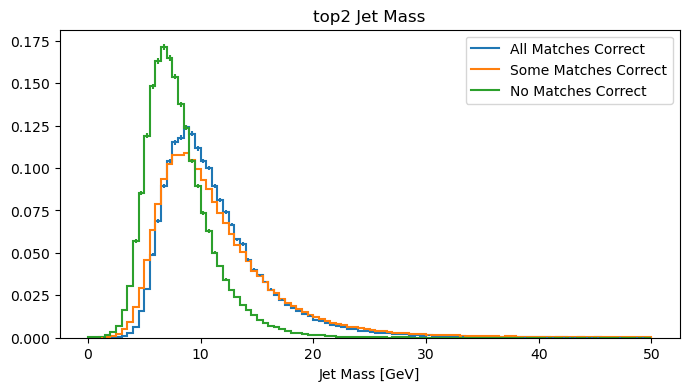

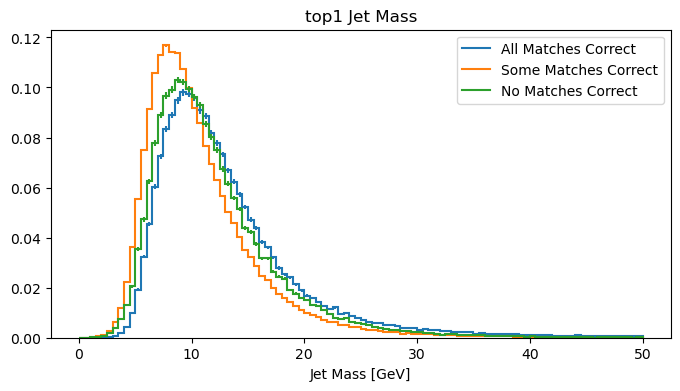

In [12]:
#### mass histogram ####

# binning
mass_low = 0.0
mass_high = 50.0
mass_numbins = 100
legend_list = ["All Matches Correct", "Some Matches Correct", "No Matches Correct"]

# define histogram
h = hist.Hist(
    hist.axis.Regular(mass_numbins, mass_low, mass_high, 
                      name="jetmass", label="Jet Mass [GeV]", flow=False),
    hist.axis.StrCategory(legend_list, name="truthlabel", label="Truth Label"),
    hist.axis.StrCategory(["W","top1","top2"], name="category", label="Category"),
)

# fill histogram
h.fill(jetmass = all_correct[:,15], category="W", truthlabel="All Matches Correct")
h.fill(jetmass = some_correct[:,15], category="W", truthlabel="Some Matches Correct")
h.fill(jetmass = none_correct[:,15], category="W", truthlabel="No Matches Correct")
h.fill(jetmass = all_correct[:,16], category="W", truthlabel="All Matches Correct")
h.fill(jetmass = some_correct[:,16], category="W", truthlabel="Some Matches Correct")
h.fill(jetmass = none_correct[:,16], category="W", truthlabel="No Matches Correct")
h.fill(jetmass = all_correct[:,17], category="top2", truthlabel="All Matches Correct")
h.fill(jetmass = some_correct[:,17], category="top2", truthlabel="Some Matches Correct")
h.fill(jetmass = none_correct[:,17], category="top2", truthlabel="No Matches Correct")
h.fill(jetmass = all_correct[:,18], category="top1", truthlabel="All Matches Correct")
h.fill(jetmass = some_correct[:,18], category="top1", truthlabel="Some Matches Correct")
h.fill(jetmass = none_correct[:,18], category="top1", truthlabel="No Matches Correct")

# make plots
fig,ax = plt.subplots(1,1,figsize=(8,4))
h[:, :, "W"].plot(density=True, ax=ax)
ax.legend(legend_list)
ax.set_title("W Jet Mass")
# fig.show()

fig,ax = plt.subplots(1,1,figsize=(8,4))
h[:, :, "top2"].plot(density=True, ax=ax)
ax.legend(legend_list)
ax.set_title("top2 Jet Mass")
fig.show()

fig,ax = plt.subplots(1,1,figsize=(8,4))
h[:, :, "top1"].plot(density=True, ax=ax)
ax.legend(legend_list)
ax.set_title("top1 Jet Mass")
fig.show()

# Model Optimization

The model used here is `xgboost`'s gradient-boosted decision tree (`XGBClassifier`). `hyperopt` is used to optimize the model parameters. A grid search to optimize model parameters can be a bit inconvenient, so `hyperopt`'s `fmin` function uses Bayesian methods to create a probabilistic model of the given parameter space and selects new values based on prior trials.

The workflow outlined here is inspired by https://towardsdatascience.com/training-xgboost-with-mlflow-experiments-and-hyperopt-c0d3a4994ea6.

TODO: Add tracking in `MLFlow`

In [10]:
import xgboost as xgb
from hyperopt import hp, STATUS_OK, fmin, tpe, Trials
from hyperopt.pyll.base import scope
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

In [11]:
features = np.array(output['features']['ttbar__nominal'])
labels = np.array(output['labels']['ttbar__nominal'])
labels = labels.reshape((len(labels),))
# which_combination = np.array(output['which_combination']['ttbar__nominal'])[:,1]

# only consider combinations that are 100% correct or 0% correct
# features = features[(labels==1) | (labels==0)]
# labels = labels[(labels==1) | (labels==0)]

# consider all combination (partially correct is same as 0% correct for training)
labels[labels==-1]=0

In [12]:
### separate data into train/val/testr ###

RANDOM_SEED = 5
TRAIN_RATIO = 0.9 # approx. fraction of data to use for training (round to nearest multiple of 12)
TRAIN_SIZE = int(TRAIN_RATIO*(features.shape[0]/12))*12

features_unflattened = features.reshape((int(features.shape[0]/12),12,19))
labels_unflattened = labels.reshape((int(features.shape[0]/12),12))

features_train_and_val, features_test, labels_train_and_val, labels_test = train_test_split(features_unflattened, 
                                                                                            labels_unflattened, 
                                                                                            train_size=TRAIN_RATIO, 
                                                                                            random_state=RANDOM_SEED)

print("features_train_and_val.shape = ", features_train_and_val.shape)
print("labels_train_and_val.shape = ", labels_train_and_val.shape)
print("features_test.shape = ", features_test.shape)
print("labels_test.shape = ", labels_test.shape)

which_combination_test = np.where(labels_test==1)[1]
features_test = features_test.reshape((12*features_test.shape[0],19))
labels_test = labels_test.reshape((12*labels_test.shape[0],))

TRAIN_RATIO = 0.9
features_train, features_val, labels_train, labels_val = train_test_split(features_train_and_val, 
                                                                          labels_train_and_val, 
                                                                          train_size=TRAIN_RATIO,
                                                                          # stratify=labels_train_and_val, # makes sure sig/bkg is balanced since we have more bkg as sig
                                                                          random_state=RANDOM_SEED)


print()
print("features_train.shape = ", features_train.shape)
print("labels_train.shape = ", labels_train.shape)
print("features_val.shape = ", features_val.shape)
print("labels_val.shape = ", labels_val.shape)

which_combination_train = np.where(labels_train==1)[1]
features_train = features_train.reshape((12*features_train.shape[0],19))
labels_train = labels_train.reshape((12*labels_train.shape[0],))

which_combination_val = np.where(labels_val==1)[1]
features_val = features_val.reshape((12*features_val.shape[0],19))
labels_val = labels_val.reshape((12*labels_val.shape[0],))

features_train_and_val.shape =  (112500, 12, 19)
labels_train_and_val.shape =  (112500, 12)
features_test.shape =  (12500, 12, 19)
labels_test.shape =  (12500, 12)

features_train.shape =  (101250, 12, 19)
labels_train.shape =  (101250, 12)
features_val.shape =  (11250, 12, 19)
labels_val.shape =  (11250, 12)


In [13]:
features_train = features_train[:36000,:]
labels_train = labels_train[:36000]
which_combination_train = which_combination_train[:int(36000/12)]

features_val = features_val[:6000,:]
which_combination_val = which_combination_val[:int(6000/12)]
labels_val = labels_val[:6000]

features_test = features_test[:6000,:]
labels_test = labels_test[:6000]
which_combination_test = which_combination_test[:int(6000/12)]

In [14]:
# preprocess features so that they are more Gaussian-like
power = PowerTransformer(method='yeo-johnson', standardize=True)

features_train = power.fit_transform(features_train)
features_val =power.transform(features_val)
features_test = power.transform(features_test)

In [15]:
# hyperopt trial values
trial_params = {
    'max_depth': scope.int(hp.quniform('max_depth', 2, 20, 1)), # maximum depth of BDT
    'n_estimators': scope.int(hp.uniform('n_estimators', 50, 700)), # number of gradient boosts applied to tree
    'learning_rate': hp.loguniform('learning_rate', -5, 0), # learning rate of boosts
    'min_child_weight': hp.loguniform('min_child_weight', -1, 7), # minimum weight needed in child node
    'reg_alpha': hp.loguniform('reg_alpha', -10, 10),
    'reg_lambda': hp.loguniform('reg_lambda', -10, 10),
    'gamma': hp.loguniform('gamma', -10, 10), # minimum loss reduction for a partition to occur
    'booster': 'gbtree', # use a boosted decision tree
    'random_state': RANDOM_SEED, # use same model initialization for each trial
    # 'eval_metric': 'auc', # hyperopt will attempt to maximize AUC
               }

In [16]:
permutation_labels = np.array([[24,24,6,-6],[24,24,-6,6],[24,6,24,-6],[24,-6,24,6],
                               [24,6,-6,24],[24,-6,6,24],[6,24,24,-6],[-6,24,24,6],
                               [6,24,-6,24],[-6,24,6,24],[6,-6,24,24],[-6,6,24,24]])

In [17]:
evaluation_matrix = np.zeros((12,12))
for i in range(len(permutation_labels)):
    for j in range(len(permutation_labels)):
        evaluation_matrix[i,j]=sum(np.equal(permutation_labels[i,:],permutation_labels[j,:]))/4
print(evaluation_matrix)

[[1.   0.5  0.5  0.25 0.25 0.5  0.5  0.25 0.25 0.5  0.   0.  ]
 [0.5  1.   0.25 0.5  0.5  0.25 0.25 0.5  0.5  0.25 0.   0.  ]
 [0.5  0.25 1.   0.5  0.5  0.25 0.5  0.25 0.   0.   0.25 0.5 ]
 [0.25 0.5  0.5  1.   0.25 0.5  0.25 0.5  0.   0.   0.5  0.25]
 [0.25 0.5  0.5  0.25 1.   0.5  0.   0.   0.5  0.25 0.25 0.5 ]
 [0.5  0.25 0.25 0.5  0.5  1.   0.   0.   0.25 0.5  0.5  0.25]
 [0.5  0.25 0.5  0.25 0.   0.   1.   0.5  0.5  0.25 0.5  0.25]
 [0.25 0.5  0.25 0.5  0.   0.   0.5  1.   0.25 0.5  0.25 0.5 ]
 [0.25 0.5  0.   0.   0.5  0.25 0.5  0.25 1.   0.5  0.5  0.25]
 [0.5  0.25 0.   0.   0.25 0.5  0.25 0.5  0.5  1.   0.25 0.5 ]
 [0.   0.   0.25 0.5  0.25 0.5  0.5  0.25 0.5  0.25 1.   0.5 ]
 [0.   0.   0.5  0.25 0.5  0.25 0.25 0.5  0.25 0.5  0.5  1.  ]]


In [18]:
mlflow.set_tracking_uri("https://mlflow.software-dev.ncsa.cloud")
EXPERIMENT_ID = mlflow.set_experiment('optimize-reconstruction-bdt-00')

In [19]:
%env MLFLOW_TRACKING_URI=https://mlflow.software-dev.ncsa.cloud
%env MLFLOW_S3_ENDPOINT_URL=https://mlflow-minio-api.software-dev.ncsa.cloud
%env AWS_ACCESS_KEY_ID=bengal1
%env AWS_SECRET_ACCESS_KEY=leftfoot1

env: MLFLOW_TRACKING_URI=https://mlflow.software-dev.ncsa.cloud
env: MLFLOW_S3_ENDPOINT_URL=https://mlflow-minio-api.software-dev.ncsa.cloud
env: AWS_ACCESS_KEY_ID=bengal1
env: AWS_SECRET_ACCESS_KEY=leftfoot1


In [20]:
current_experiment=dict(mlflow.get_experiment_by_name('optimize-reconstruction-bdt-00'))
EXP_ID=current_experiment['experiment_id']

In [21]:
# training method for hyperopt
def train_and_evaluate(params):
    
    # mlflow.xgboost.autolog()
    
    with mlflow.start_run(experiment_id=EXP_ID, nested=True):
    
        model = xgb.XGBClassifier(**params) # define model with current parameters
        model = model.fit(features_train, labels_train) # train model
        
        mlflow.log_params(params)

        # predicting train set and validation set
        train_predicted = model.predict(features_train)
        train_predicted_prob = model.predict_proba(features_train)[:, 1]
        val_predicted = model.predict(features_val)
        val_predicted_prob = model.predict_proba(features_val)[:, 1]

        # model metrics to track
        metric_names = ['accuracy', 'precision', 'recall', 'f1', 'aucroc']

        # Training evaluation metrics
        train_metrics = {
            'Accuracy': accuracy_score(labels_train, train_predicted), 
            'Precision': precision_score(labels_train, train_predicted, zero_division=0), 
            'Recall': recall_score(labels_train, train_predicted), 
            'F1': f1_score(labels_train, train_predicted), 
            'AUCROC': roc_auc_score(labels_train, train_predicted_prob),
        }

        # Validation evaluation metrics
        val_metrics = {
            'Accuracy': accuracy_score(labels_val, val_predicted), 
            'Precision': precision_score(labels_val, val_predicted, zero_division=0), 
            'Recall': recall_score(labels_val, val_predicted), 
            'F1': f1_score(labels_val, val_predicted), 
            'AUCROC': roc_auc_score(labels_val, val_predicted_prob),
        }

        train_predicted_prob = train_predicted_prob.reshape((int(len(train_predicted_prob)/12),12))
        train_predicted_combination = np.argmax(train_predicted_prob,axis=1)

        scores = np.zeros(len(which_combination_train))
        zipped = list(zip(which_combination_train.tolist(), train_predicted_combination.tolist()))
        for i in range(len(which_combination_train)):
            scores[i] = evaluation_matrix[zipped[i]]
        score_train = -sum(scores)/len(scores)
        
        val_predicted_prob = val_predicted_prob.reshape((int(len(val_predicted_prob)/12),12))
        val_predicted_combination = np.argmax(val_predicted_prob,axis=1)

        scores = np.zeros(len(which_combination_val))
        zipped = list(zip(which_combination_val.tolist(), val_predicted_combination.tolist()))
        for i in range(len(which_combination_val)):
            scores[i] = evaluation_matrix[zipped[i]]
        score_val = -sum(scores)/len(scores)
        
        train_metrics["Jet-Accuracy"] = -score_train
        train_metrics_values = list(train_metrics.values())
        
        val_metrics["Jet-Accuracy"] = -score_val
        val_metrics_values = list(val_metrics.values())
        
        # Logging model signature, class, and name
        signature = infer_signature(features_train, val_predicted)
        mlflow.xgboost.log_model(model, 'model', signature=signature)
        mlflow.set_tag('estimator_name', model.__class__.__name__)
        mlflow.set_tag('estimator_class', model.__class__)

        metric_names = ['accuracy', 'precision', 'recall', 'f1', 'aucroc', "jet-accuracy"]
        # Logging each metric
        for name, metric in list(zip(metric_names, train_metrics_values)):
            mlflow.log_metric(f'training_{name}', metric)
        for name, metric in list(zip(metric_names, val_metrics_values)):
            mlflow.log_metric(f'validation_{name}', metric)

    return {'status': STATUS_OK, 'loss': score_val}

In [22]:
trials = Trials()

# optimize model
with mlflow.start_run(experiment_id=EXP_ID, run_name='xgboost_bdt_models'):
    best_parameters = fmin(
        fn=train_and_evaluate, 
        space=trial_params,
        algo=tpe.suggest,
        trials=trials,
        max_evals=40 # how many trials to run
                          )

  0%|          | 0/40 [00:00<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



100%|██████████| 40/40 [08:17<00:00, 12.45s/trial, best loss: -0.6885]


In [23]:
# convert max_depth and n_estimators to integers
best_parameters['max_depth'] = int(best_parameters['max_depth'])
best_parameters['n_estimators'] = int(best_parameters['n_estimators'])

In [24]:
print("Best Model Parameters = ", best_parameters)

Best Model Parameters =  {'gamma': 4.882946291535679e-05, 'learning_rate': 0.9797579229034632, 'max_depth': 17, 'min_child_weight': 1.538909137007334, 'n_estimators': 676, 'reg_alpha': 0.0004598264808611254, 'reg_lambda': 1158.8269620507972}


# Training/Evaluation with Optimized Model

In [25]:
# define and fit model to data
model = xgb.XGBClassifier(**best_parameters)
model = model.fit(features_train, labels_train)

In [26]:
# make predictions
train_predicted = model.predict(features_train)
train_predicted_prob = model.predict_proba(features_train)[:, 1]
val_predicted = model.predict(features_val)
val_predicted_prob = model.predict_proba(features_val)[:, 1]

In [27]:
train_accuracy = accuracy_score(labels_train, train_predicted).round(3)
train_precision = precision_score(labels_train, train_predicted).round(3)
train_recall = recall_score(labels_train, train_predicted).round(3)
train_f1 = f1_score(labels_train, train_predicted).round(3)
train_aucroc = roc_auc_score(labels_train, train_predicted_prob).round(3)
print("Training Accuracy = ", train_accuracy)
print("Training Precision = ", train_precision)
print("Training Recall = ", train_recall)
print("Training f1 = ", train_f1)
print("Training AUC = ", train_aucroc)
print()

val_accuracy = accuracy_score(labels_val, val_predicted).round(3)
val_precision = precision_score(labels_val, val_predicted).round(3)
val_recall = recall_score(labels_val, val_predicted).round(3)
val_f1 = f1_score(labels_val, val_predicted).round(3)
val_aucroc = roc_auc_score(labels_val, val_predicted_prob).round(3)
print("Validation Accuracy = ", val_accuracy)
print("Validation Precision = ", val_precision)
print("Validation Recall = ", val_recall)
print("Validation f1 = ", val_f1)
print("Validation AUC = ", val_aucroc)

Training Accuracy =  0.998
Training Precision =  1.0
Training Recall =  0.974
Training f1 =  0.986
Training AUC =  1.0

Validation Accuracy =  0.922
Validation Precision =  0.584
Validation Recall =  0.222
Validation f1 =  0.322
Validation AUC =  0.873


In [28]:
val_predicted_prob = val_predicted_prob.reshape((int(len(val_predicted_prob)/12),12))
val_predicted_combination = np.argmax(val_predicted_prob,axis=1)
    
scores = np.zeros(len(which_combination_val))
zipped = list(zip(which_combination_val.tolist(), val_predicted_combination.tolist()))
for i in range(len(which_combination_val)):
    scores[i] = evaluation_matrix[zipped[i]]
        
score = -sum(scores)/len(scores)
print("Validation Jet Score = ", score)

train_predicted_prob = train_predicted_prob.reshape((int(len(train_predicted_prob)/12),12))
train_predicted_combination = np.argmax(train_predicted_prob,axis=1)
    
scores = np.zeros(len(which_combination_train))
zipped = list(zip(which_combination_train.tolist(), train_predicted_combination.tolist()))
for i in range(len(which_combination_train)):
    scores[i] = evaluation_matrix[zipped[i]]
        
score = -sum(scores)/len(scores)
print("Training Jet Score = ", score)

Validation Jet Score =  -0.6885
Training Jet Score =  -0.9996666666666667


In [29]:
# make predictions
test_predicted = model.predict(features_test)
test_predicted_prob = model.predict_proba(features_test)[:, 1]

In [30]:
test_accuracy = accuracy_score(labels_test, test_predicted).round(3)
test_precision = precision_score(labels_test, test_predicted).round(3)
test_recall = recall_score(labels_test, test_predicted).round(3)
test_f1 = f1_score(labels_test, test_predicted).round(3)
test_aucroc = roc_auc_score(labels_test, test_predicted_prob).round(3)
print("Test Accuracy = ", test_accuracy)
print("Test Precision = ", test_precision)
print("Test Recall = ", test_recall)
print("Test f1 = ", test_f1)
print("Test AUC = ", test_aucroc)

Test Accuracy =  0.922
Test Precision =  0.578
Test Recall =  0.216
Test f1 =  0.314
Test AUC =  0.868


In [31]:
test_predicted_prob = test_predicted_prob.reshape((int(len(test_predicted_prob)/12),12))
test_predicted_combination = np.argmax(test_predicted_prob,axis=1)
    
scores = np.zeros(len(which_combination_test))
zipped = list(zip(which_combination_test.tolist(), test_predicted_combination.tolist()))
for i in range(len(which_combination_test)):
    scores[i] = evaluation_matrix[zipped[i]]
        
score = sum(scores)/len(scores)
print("Test Jet Score = ", score)
print("Random Assignment Jet Score = ", 0.375)

Test Jet Score =  0.653
Random Assignment Jet Score =  0.375


In [38]:
evaluation_matrix[0,:]

array([1.  , 0.5 , 0.5 , 0.25, 0.25, 0.5 , 0.5 , 0.25, 0.25, 0.5 , 0.  ,
       0.  ])

In [40]:
print("How many events are 100% correct: ", sum(scores==1)/len(scores), ", Random = ",sum(evaluation_matrix[0,:]==1)/12)
print("How many events are 50% correct: ", sum(scores==0.5)/len(scores), ", Random = ",sum(evaluation_matrix[0,:]==0.5)/12)
print("How many events are 25% correct: ", sum(scores==0.25)/len(scores), ", Random = ",sum(evaluation_matrix[0,:]==0.25)/12)
print("How many events are 0% correct: ", sum(scores==0)/len(scores), ", Random = ",sum(evaluation_matrix[0,:]==0)/12)

How many events are 100% correct:  0.42 , Random =  0.08333333333333333
How many events are 50% correct:  0.4 , Random =  0.4166666666666667
How many events are 25% correct:  0.132 , Random =  0.3333333333333333
How many events are 0% correct:  0.048 , Random =  0.16666666666666666


In [32]:
# save model to json. this file can be used with the FIL backend in nvidia-triton!
model.save_model("models/model_allcombinations_xgb.json")

In [33]:
model = xgb.XGBClassifier()
model.load_model("models/model_allcombinations_xgb.json")